# Re Evaluate the data

In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
import toad
from toad.plot import bin_plot, badrate_plot
from toad.metrics import KS, AUC
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

## Load Data

In [2]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [3]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [4]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [5]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [6]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [7]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [8]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [9]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [10]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [10]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
857208,314144,0,Cash loans,M,Y,Y,0,157500.0,685386.0,43933.5,585000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.008625,-21732,-3531,-9004.0,-5158,1,1,0,1,0,0,2.0,2,2,THURSDAY,16,0,0,0,0,1,1,Construction,0.635595,0.0,0.0,0.0,0.0,-336.0,2441440.530,195237.0,2173652.0,Revolving loans,2250.000,45000.0,45000.0,45000.0,THURSDAY,14.0,Y,1.0,XAP,Approved,-336.0,XNA,XAP,New,XNA,Cards,walk-in,Country-wide,2200.0,Consumer electronics,0.0,XNA,Card Street,365243.0,130263.390,130263.390,0.00,399901.59,122631.57,NaN
480751,220305,0,Cash loans,F,Y,Y,2,180000.0,1214100.0,67923.0,1125000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.011657,-11991,-2619,-6209.0,-435,1,1,0,1,0,1,4.0,1,1,SATURDAY,13,0,0,0,0,1,1,Other,0.579179,4.0,0.0,4.0,0.0,0.0,NaN,NaN,1082075.0,Consumer loans,4949.505,49500.0,44550.0,49500.0,WEDNESDAY,11.0,Y,1.0,XAP,Approved,-2824.0,Cash through the bank,XAP,Repeater,Furniture,POS,XNA,Stone,414.0,Furniture,10.0,low_normal,POS industry without interest,-2548.0,49347.450,49347.450,0.00,NaN,NaN,0.000000
51462,112912,0,Cash loans,F,N,Y,0,157500.0,450000.0,35554.5,450000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.011703,-22045,-395,-1015.0,-4423,1,1,0,1,0,0,1.0,2,2,TUESDAY,8,0,0,0,0,1,1,Medicine,0.711608,0.0,0.0,0.0,0.0,-1893.0,3686829.390,979803.0,1123487.0,Cash loans,34117.155,1125000.0,1288350.0,1125000.0,WEDNESDAY,14.0,Y,1.0,Repairs,Refused,-104.0,Cash through the bank,SCO,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1.0,XNA,60.0,low_action,Cash Street: low,0.0,NaN,NaN,NaN,NaN,NaN,NaN
807000,301736,0,Cash loans,F,N,Y,0,112500.0,278460.0,21676.5,225000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.025164,-18178,-11407,-14616.0,-1707,1,1,0,1,0,0,2.0,2,2,THURSDAY,8,0,0,0,0,0,0,Other,0.482935,0.0,0.0,0.0,0.0,0.0,1678720.500,347382.0,2617697.0,Consumer loans,7358.760,67986.0,66235.5,67986.0,FRIDAY,15.0,Y,1.0,XAP,Approved,-2428.0,Cash through the bank,XAP,Repeater,Furniture,POS,XNA,Stone,40.0,Furniture,10.0,low_normal,POS industry with interest,-2127.0,80916.255,73557.495,7358.76,NaN,NaN,0.222222
649280,262474,0,Cash loans,M,N,N,0,99000.0,814041.0,23931.0,679500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.006671,-9351,-2353,-593.0,-1902,1,1,1,1,0,0,1.0,2,2,WEDNESDAY,11,0,0,0,0,1,1,Business Entity Type 3,0.711603,1.0,0.0,1.0,0.0,-1544.0,197536.500,58365.0,1864023

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


In [11]:
xna_goods = train_full.NAME_GOODS_CATEGORY.value_counts()[0]
total_data = train_full.shape[0]
print(f'Proportion of XNA values in NAME_GOODS_CATEGORY {round((xna_goods / total_data) * 100, 2)}%')

xna_client = train_full.NAME_CLIENT_TYPE.value_counts()[0]
print(f'Proportion of XNA values in NAME_CLIENT_TYPE: {round((xna_client / total_data) * 100, 2)}%')


Proportion of XNA values in NAME_GOODS_CATEGORY 55.74%
Proportion of XNA values in NAME_CLIENT_TYPE: 72.56%


for XNA wich is not not available, the value proportion is half of the data, that we have to drop this because rest of the value around 44% is too small and considered not valid. 

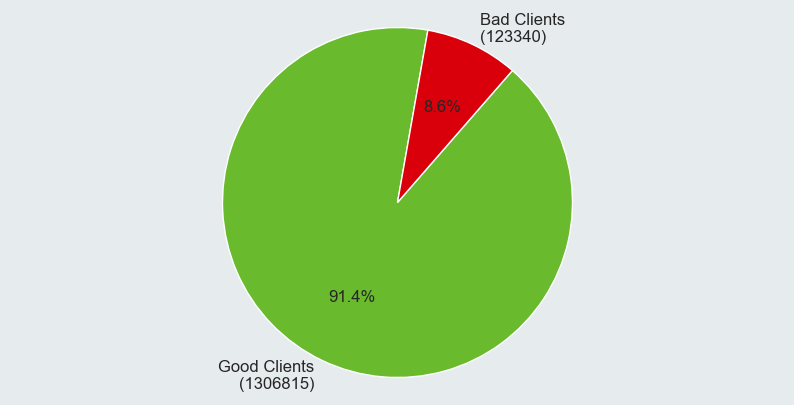

There's 1430155 Clients in our data


In [12]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()
print(f"There's {train_full.shape[0]} Clients in our data")

From the plot above, we can see that:
- From total 1430155 clients in our data.
- 1,306,815 (91.4%) clients don't have payment difficulties. 
- 123,340 (8.6%) clients have payments difficulties.
- The data is highly imbalanced.

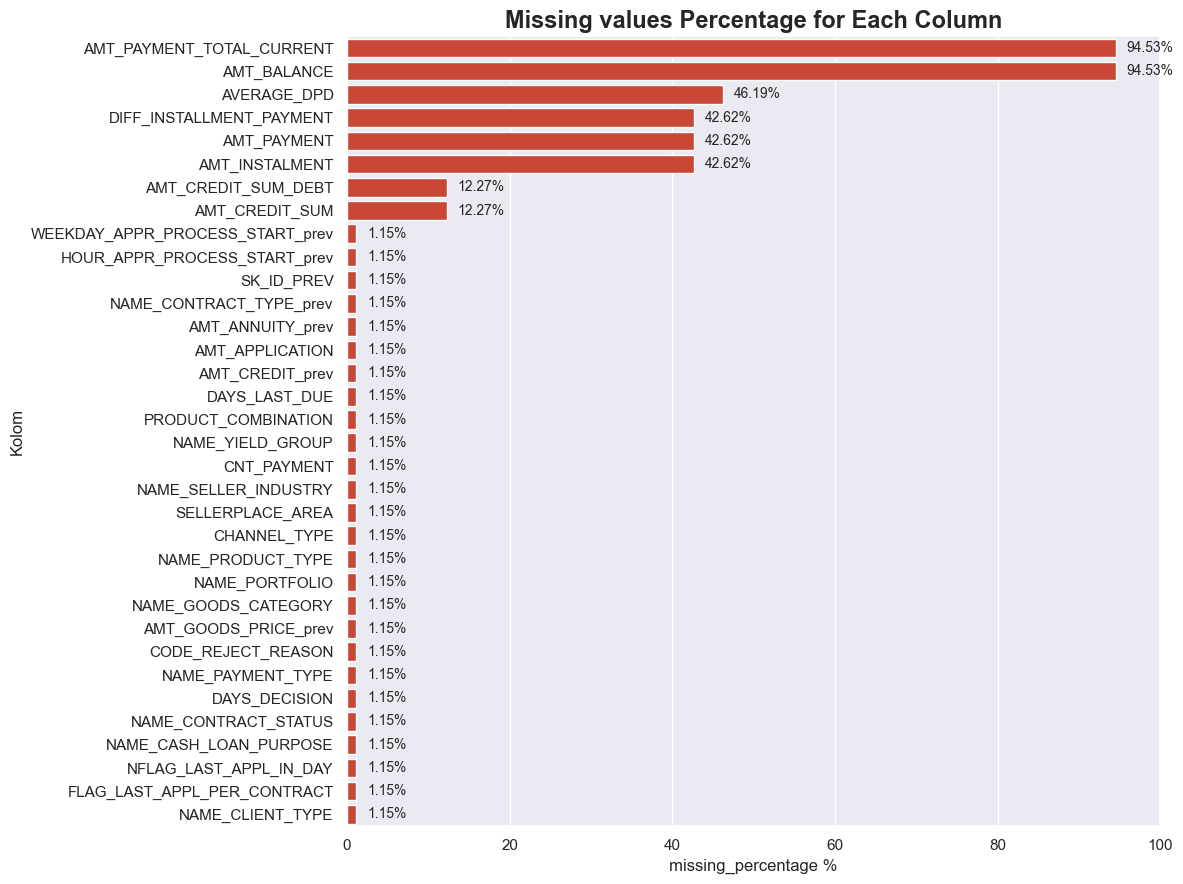

In [14]:
ms.plot_missing_percentage(train_full)

Our data Contains a lot of missing values,
- For the columns that have missing values more than 90% of the data, i will drop them.
- AVERAGE DPD missing values seems reasonable, that there's client that didn't have any DPD, or didn't have any previous application.
- for the columns `DIFF_INSTALMENT_PAYMENT`, `AMT_PAYMENT` and `AMT_INSTALMENT` i will fill the missing values with 0, because it's reasonable to assume that the client didn't have any previous application too.
- the rest of it i will leave it be, so when there's missing values, while we do woe binning, it will be treated as a separate category.

CODE_REJECT_REASON
HC        145984
LIMIT      47773
SCO        32636
CLIENT     22771
SCOFR      10875
VERIF       3079
SYSTEM       672
Name: count, dtype: int64

In [17]:
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']

# make a function to replace columns value contains XNA or XAP with np.nan
def replace_xna_xap(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace(['XNA', 'XAP'], np.nan)
    return df

train_full = replace_xna_xap(train_full)

# replace abnormal value
replace_val = {4.5 : 5,
               0.5 : 1}
train_full['CNT_FAM_MEMBERS'] = train_full['CNT_FAM_MEMBERS'].replace(replace_val)

# mapping_dict = {'Family' : 'Companied',
#                 'Spouse, partner': 'Companied',
#                 'Children': 'Companied',
#                 'Other_A': 'Companied',
#                 'Other_B': 'Companied',
#                 'Group of people': 'Companied'}
# train_full = train_full.replace({'NAME_TYPE_SUITE': mapping_dict})

# map_income_val = {'Unemployed': 'Others', 
#                   'Student': 'Others', 
#                   'Materniity leave': 'Others',
#                   'Businessman': 'Others'}

# train_full = train_full.replace({'NAME_INCOME_TYPE': map_income_val})

In [238]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']
# train_full = train_full.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                       'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE'], axis=1)

replace_nan = {'XNA': np.nan}
train_full['NAME_YIELD_GROUP'] = train_full['NAME_YIELD_GROUP'].replace(replace_nan)

# mapping_dict = {'Family' : 'Companied',
#                 'Spouse, partner': 'Companied',
#                 'Children': 'Companied',
#                 'Other_A': 'Companied',
#                 'Other_B': 'Companied',
#                 'Group of people': 'Companied'}
# train_full = train_full.replace({'NAME_TYPE_SUITE': mapping_dict})

# map_income_val = {'Unemployed': 'Others', 
#                   'Student': 'Others', 
#                   'Materniity leave': 'Others',
#                   'Businessman': 'Others'}

# train_full = train_full.replace({'NAME_INCOME_TYPE': map_income_val})

train_full = train_full.drop(columns=['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

## Oulier Cheking

In [16]:
# numvisual = train_full[[
#     'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
#     'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
#     'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
#     'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
#     'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
#     'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
#     'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
#     'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
#     'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
#     'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
#     'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
#     'AVERAGE_DPD'
#           ]].copy()

# colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# # Create a 9x4 grid of subplots
# fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# # for each group of 4 columns
# for i, group in enumerate(colgroup):
#     # For eachg column in the group
#     for j, column in enumerate(group):
#         # Create a boxplot for the apporopriate subplot
#         sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
#         axs[j, i].set_title(column)

# # show plot
# plt.tight_layout()
# plt.show()

## Train Test Split

In [18]:
X = train_full.drop(columns='TARGET', axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## Handle Missing Values

In [18]:
# # X train missing values handling
# fillzero = ['AVERAGE_DPD', 'DIFF_INSTALLMENT_PAYMENT', 'AMT_PAYMENT', 'AMT_INSTALMENT']
# X_train_c1 = ms.dropnan(X_train, 0.9)
# X_train_c2 = X_train_c1.copy()
# X_train_c2[fillzero] = X_train_c2[fillzero].fillna(0)


# # train_missing = X_train_c2[X_train_c2.columns[X_train_c2.isna().any()]] 
# # traincol = train_missing.columns

# # for col in traincol:
# #     if X_train_c2[col].dtype == 'object':
# #         X_train_c2[col].fillna(X_train_c2[col].mode()[0], inplace=True)
# #     else:
# #         X_train_c2[col].fillna(X_train_c2[col].median(), inplace=True)


# # X test missing values handling
# X_test_c1 = ms.dropnan(X_test, 0.9)
# X_test_c2 = X_test[fillzero].fillna(0)


# # test_missing = X_test_c2[X_test_c2.columns[X_test_c2.isna().any()]]
# # testcol = test_missing.columns

# # for col in testcol:
# #     if X_test_c2[col].dtype == 'object':
# #         X_test_c2[col].fillna(X_test_c2[col].mode()[0], inplace=True)
# #     else:
# #         X_test_c2[col].fillna(X_test_c2[col].median(), inplace=True)

## Data filtering

In [19]:
toad.quality(X_train, target=y_train['TARGET'], iv_only=True)

,iv,gini,entropy,unique
EXT_SOURCE_2,0.286217,NaN,NaN,116293.0
DAYS_EMPLOYED,0.101107,NaN,NaN,12433.0
AMT_GOODS_PRICE_curr,0.090048,NaN,NaN,977.0
DAYS_BIRTH,0.078253,NaN,NaN,17445.0
AGE,0.077581,NaN,NaN,49.0
...,...,...,...,...
NFLAG_LAST_APPL_IN_DAY,0.000133,NaN,NaN,3.0
REG_REGION_NOT_LIVE_REGION,0.000119,NaN,NaN,2.0
FLAG_EMAIL,0.000024,NaN,NaN,2.0
FLAG_MOBIL,0.000023,NaN,NaN,2.0


In [20]:
# train_selected, drop_list = toad.selection.select(frame=train_full,
#                                                   target=train_full['TARGET'],
#                                                   empty=0.5,
#                                                   iv=0.02,
#                                                   corr=0.7,
#                                                   return_drop=True)

# print(f'Number of features selected: {len(train_selected.columns)}')
# print(f'Number of features dropped: {len(drop_list)}')

In [20]:
Xtrain_selected, drop_list = toad.selection.select(frame=X_train,
                                                  target=y_train['TARGET'],
                                                  empty=0.5,
                                                  iv=0.02,
                                                  corr=0.7,
                                                  return_drop=True)

print("keep:",Xtrain_selected.shape[1],
      "drop empty:",len(drop_list['empty']),
      "drop iv:",len(drop_list['iv']),
      "drop corr:",len(drop_list['corr']))

display(Xtrain_selected)
print(f'\n{drop_list}')

keep: 24 drop empty: 7 drop iv: 42 drop corr: 6


,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
7003,M,225000.0,Working,Incomplete higher,0.018801,-9142,-746,-4016.0,-1805,2,1,Business Entity Type 3,0.402901,-1393.0,46462.500,Approved,-1393.0,6.0,high,POS household with interest,-1212.0,31133.970,5194.845,0.000000
792634,M,225000.0,Commercial associate,Secondary / secondary special,0.046220,-9036,-149,-1079.0,-1506,1,0,Business Entity Type 3,0.733094,-676.0,139437.000,Approved,-398.0,6.0,middle,POS household with interest,-217.0,96675.255,16112.745,0.714286
604873,F,225000.0,Commercial associate,Secondary / secondary special,0.014520,-11704,-732,-4347.0,-4374,2,1,Self-employed,0.344191,-238.0,533709.000,Approved,-2587.0,6.0,high,POS mobile with interest,-2402.0,22579.785,0.000,0.000000
360692,M,675000.0,Commercial associate,Higher education,0.019689,-12562,-1257,-6477.0,-3825,2,0,Business Entity Type 3,0.473022,-1438.0,220599.000,Approved,-1409.0,6.0,middle,POS household with interest,-1227.0,126868.680,21145.455,0.000000
1389608,F,238500.0,Working,Secondary / secondary special,0.035792,-14333,-983,-7818.0,-4610,2,1,Self-employed,0.020813,-602.0,35860.500,Canceled,-169.0,0.0,NaN,Cash,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,F,270000.0,Commercial associate,Incomplete higher,0.031329,-10380,-921,-4866.0,-3042,2,1,Business Entity Type 1,0.444848,-954.0,69386.355,Approved,-2380.0,6.0,high,POS mobile with interest,-2259.0,27904.050,0.000,0.000000
1419949,F,405000.0,Pensioner,Secondary / secondary special,0.025164,-20659,365243,-4696.0,-4150,2,0,NaN,0.194499,-593.0,108.000,Approved,-1155.0,0.0,NaN,Card X-Sell,-526.0,592256.520,0.000,NaN
734248,F,801000.0,State servant,Secondary / secondary special,0.015221,-14070,-6650,-8163.0,-5151,2,0,Other,0.499346,-1110.0,49782.240,Approved,-665.0,0.0,NaN,Card X-Sell,365243.0,NaN,NaN,NaN
509864,F,409500.0,Commercial associate,Secondary / secondary special,0.002134,-10528,-342,-4236.0,-185,3,1,Trade: type 7,0.239021,-872.0,NaN,Canceled,-382.0,0.0,NaN,Cash,0.0,NaN,NaN,NaN



{'empty': array(['NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON',
       'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY',
       'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT'], dtype='<U25'), 'iv': array(['SK_ID_CURR', 'NAME_CONTRACT_TYPE_curr', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START_curr',
       'HOUR_APPR_PROCESS_START_curr', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_CREDIT_SUM', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE_prev',
       'AMT_ANNUITY_prev', 'AMT_APPLICATION', 'AMT_CR

In [22]:
selected_features = Xtrain_selected.columns

X_test = X_test[selected_features]

In [23]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(Xtrain_selected, y_train['TARGET'])

In [24]:
df_iv.sort_values(by='iv', ascending=False)

,name,iv
0,EXT_SOURCE_2,0.286217
1,DAYS_EMPLOYED,0.101107
2,AMT_GOODS_PRICE_curr,0.090048
3,DAYS_BIRTH,0.078253
4,ORGANIZATION_TYPE,0.069430
5,AMT_CREDIT_SUM_DEBT,0.069113
6,NAME_INCOME_TYPE,0.056952
7,DAYS_LAST_PHONE_CHANGE,0.055948
8,REGION_RATING_CLIENT_W_CITY,0.046869
9,PRODUCT_COMBINATION,0.043714


## Handling Outlier

In [282]:
def cap_outliers(data, columns):
    # Create a copy of the data to avoid modifying the original DataFrame
    result = data.copy()

    # Loop over each column in the provided list
    for col in columns:
        # Calculate the first quartile (Q1) for the current column
        Q1 = result[col].quantile(0.25)
        # Calculate the third quartile (Q3) for the current column
        Q3 = result[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1
        # Calculate the lower bound for the current column
        lower_bound = Q1 - (1.5 * IQR)
        # Calculate the upper bound for the current column
        upper_bound = Q3 + (1.5 * IQR)
        # Replace values in the current column that are less than the lower bound with the lower bound
        result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
        # Replace values in the current column that are greater than the upper bound with the upper bound
        result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
    # Return the DataFrame with capped outliers
    return result


# Select the names of all numerical columns in the DataFrame X_train_c2
outliers = Xtrain_selected.select_dtypes(include='number').columns

# Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# This will cap the outliers in these columns, and the result is stored in X_train_c3
Xtrain_selected = cap_outliers(Xtrain_selected, outliers)

## Feature Binning

In [25]:
# combine x_train and y_train
train = pd.concat([Xtrain_selected, y_train], axis=1)
sample = train.sample(frac=0.25, random_state=1103)

c = toad.transform.Combiner()
c.fit(X=sample.drop('TARGET', axis=1), y=sample['TARGET'], method='dt', n_bins=None, empty_separate=True)

In [284]:
bins_output = c.export()
bins_output

{'CODE_GENDER': [['XNA'], ['F'], ['M']],
 'AMT_GOODS_PRICE_curr': [138321.0,
  342411.75,
  416929.5,
  450117.0,
  461112.75,
  462789.0,
  632250.0,
  675191.25,
  677889.0],
 'NAME_INCOME_TYPE': [['Pensioner'],
  ['State servant'],
  ['Commercial associate'],
  ['Working'],
  ['Student', 'Businessman'],
  ['Maternity leave'],
  ['Unemployed']],
 'NAME_EDUCATION_TYPE': [['Academic degree'],
  ['Higher education'],
  ['Incomplete higher'],
  ['Secondary / secondary special'],
  ['Lower secondary']],
 'REGION_POPULATION_RELATIVE': [0.0007354999834205955,
  0.002319999970495701,
  0.017320500686764717,
  0.018118999898433685,
  0.018825500272214413,
  0.019967499189078808,
  0.021668999455869198,
  0.0319449994713068,
  0.05936400033533573],
 'DAYS_BIRTH': [-23244.5,
  -19914.5,
  -14786.5,
  -14745.5,
  -14744.5,
  -13426.5,
  -11602.5,
  -8783.5,
  -8579.5],
 'DAYS_EMPLOYED': [-9768.5,
  -3047.5,
  -1475.5,
  -1472.5,
  -933.5,
  -923.5,
  -189.5,
  -15.5,
  182621.5],
 'DAYS_REGISTRA

In [66]:
# # transform combiner into train and test
# tf_train_bin = c.transform(train)

# # combine X_test and y_test
# test = pd.concat([X_test, y_test], axis=1)
# tf_test_bin = c.transform(test[tf_train_bin.columns])

In [67]:
# bin_plot(tf_train_bin, x='DAYS_EMPLOYED', target='TARGET')
# bin_plot(tf_test_bin, x='DAYS_EMPLOYED', target='TARGET')

## Transform WoE

In [68]:
# # transform training set
# train_woe = td.fit_transform(X=tf_train_bin, y='TARGET')

# # transform test set
# test_woe = td.transform(tf_test_bin)

In [47]:
# intialize the WOE transformer
td = toad.transform.WOETransformer()

# Transform the data into WoE values
Xtrain_selected_woe = td.fit_transform(c.transform(Xtrain_selected), y_train['TARGET'])

# transform test set
Xtest_selected_woe = td.fit_transform(c.transform(X_test), y_test['TARGET'])

# Calculate the Information Value (IV) for each feature
iv = toad.quality(Xtrain_selected_woe, y_train['TARGET'], iv_only=True)

iv

,iv,gini,entropy,unique
EXT_SOURCE_2,0.283937,NaN,NaN,10.0
DAYS_EMPLOYED,0.096811,NaN,NaN,10.0
AMT_GOODS_PRICE_curr,0.085123,NaN,NaN,10.0
DAYS_BIRTH,0.077075,NaN,NaN,10.0
AMT_CREDIT_SUM_DEBT,0.068029,NaN,NaN,11.0
ORGANIZATION_TYPE,0.067394,NaN,NaN,10.0
NAME_INCOME_TYPE,0.056963,NaN,NaN,7.0
DAYS_LAST_PHONE_CHANGE,0.054603,NaN,NaN,10.0
REGION_RATING_CLIENT_W_CITY,0.046869,NaN,NaN,3.0
PRODUCT_COMBINATION,0.043324,NaN,NaN,10.0


## Model building

Train AUC: 0.7126974761257722
Test AUC: 0.7150834048960193
Train Recall: 0.6532968636820654
Test Recall: 0.654443471776416


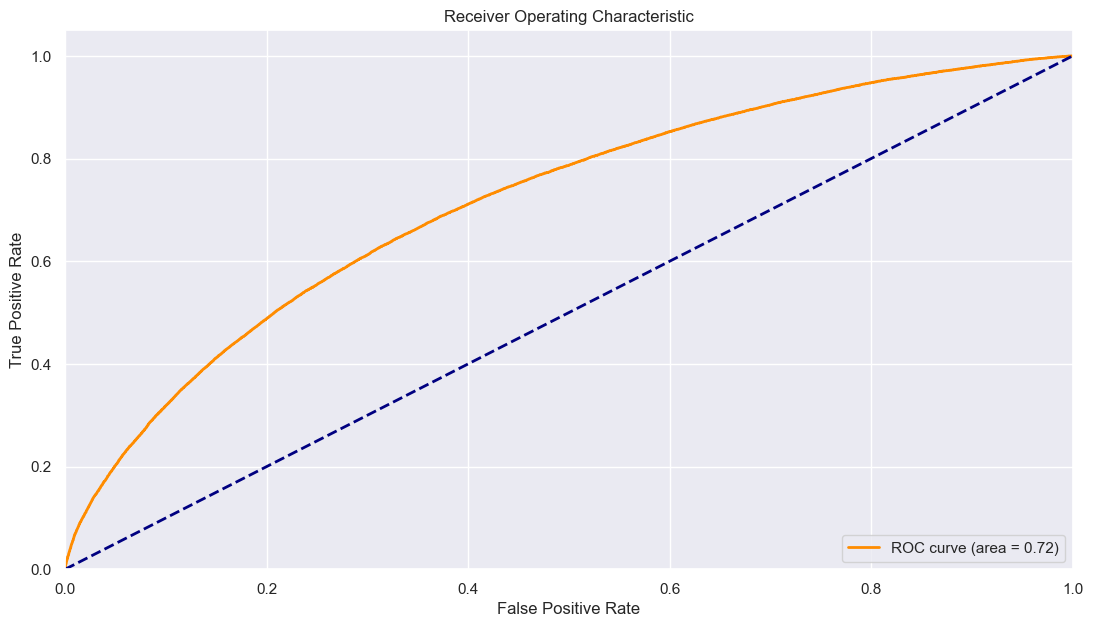

In [53]:
def train_test_auc(X_train, y_train, X_test, y_test):
    lr = LogisticRegression(random_state=1103, class_weight='balanced', C= 0.1, solver='liblinear', penalty='l2')
    lr.fit(X_train, y_train)

    pred_train = lr.predict_proba(X_train)[:, 1]
    pred_test = lr.predict_proba(X_test)[:, 1]

    # print('Train KS:', KS(pred_train, y_train))
    # print('Test_KS:', KS(pred_test, y_test))

    print('Train AUC:', AUC(pred_train, y_train))
    print('Test AUC:', AUC(pred_test, y_test))

    print('Train Recall:', recall_score(y_train, pred_train > 0.5))
    print('Test Recall:', recall_score(y_test, pred_test > 0.5))

    fig, ax = plt.subplots(figsize=(13, 7))
    
    fpr, tpr, _ = roc_curve(y_test, pred_test)
    roc_auc = roc_auc_score(y_test, pred_test)

    # Plot ROC Curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# X_train2 = Xtrain_selected_woe.copy()
# y_train2 = y_train.copy()
# X_test2 = Xtest_selected_woe.copy()
# y_test2 = y_test.copy()
train_test_auc(X_train=Xtrain_selected_woe, y_train=y_train,
               X_test=Xtest_selected_woe, y_test=y_test)

The KS (Kolmogorov-Smirnov) statistic and AUC (Area Under the ROC Curve) are both metrics used to evaluate the performance of a binary classification model.

1. **AUC**: The AUC measures the area under the ROC curve, which plots the true positive rate against the false positive rate at various threshold settings. The AUC ranges from 0 to 1, where a value of 0.5 corresponds to a model that makes random predictions, and a value of 1 corresponds to a model that makes perfect predictions. In our case, the AUC is around 0.70 for both the training and test sets, which suggests that our model has a good predictive performance.

The fact that the KS and AUC values are similar for the training and test sets is a good sign. It suggests that our model is not overfitting to the training data, as it performs similarly on unseen data (the test set).

In [31]:
# Hyperparameter tuning Logistic Regression model
penalty = ['l1', 'l2', 'elasticnet', None]
C = [0.1, 1, 10, 100]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['balanced', None]
max_iter = [100, 500, 1000, 1500]

param_distributions = dict(penalty=penalty, C=C, solver=solver, class_weight=class_weight, max_iter=max_iter)

lr = LogisticRegression(random_state=1103)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)
rs = RandomizedSearchCV(lr, param_distributions=param_distributions, cv=cv, scoring='roc_auc')

rs_result = rs.fit(Xtrain_selected_woe, y_train)

print(f'Best: {rs_result.best_score_} using {rs_result.best_params_}')

Best: 0.7125975836657334 using {'solver': 'lbfgs', 'penalty': None, 'max_iter': 1500, 'class_weight': 'balanced', 'C': 1}


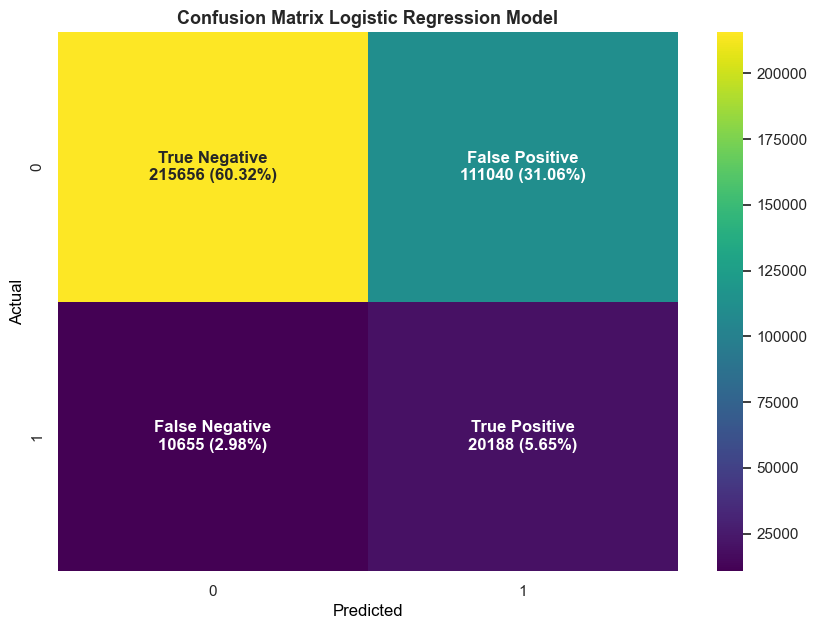

In [55]:
lr = LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100, class_weight='balanced', C=1, random_state=1103)

# Fit the model
lr.fit(Xtrain_selected_woe, y_train)
# Assuming X_test is your test dataset and model is your Gradient Boosting model
y_pred_test = lr.predict(Xtest_selected_woe)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_test)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.show()

## Scorecard Model

In [56]:
# Create a new model with the best parameters
logreg_new = LogisticRegression(random_state=1103, class_weight='balanced', C= 0.1, solver='liblinear', penalty='l2')

# Fit the new model to the data
logreg_new.fit(Xtrain_selected_woe, y_train)

logreg_new_pred = logreg_new.predict(Xtest_selected_woe)
logreg_new_pred_train = logreg_new.predict(Xtrain_selected_woe)
logreg_new_pred_proba = logreg_new.predict_proba(Xtest_selected_woe)[:,1]
logreg_new_pred_proba_train = logreg_new.predict_proba(Xtrain_selected_woe)[:,1]

# Print the classification report
print(classification_report(y_test, logreg_new_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, logreg_new_pred))

# Print the AUC
print('Train AUC:', roc_auc_score(y_train, logreg_new_pred_proba_train))
print('Test AUC:', roc_auc_score(y_test, logreg_new_pred_proba))

# Print the recall
print('Train Recall:', recall_score(y_train, logreg_new_pred_train))
print('Test Recall:', recall_score(y_test, logreg_new_pred))


              precision    recall  f1-score   support

           0       0.95      0.66      0.78    326696
           1       0.15      0.65      0.25     30843

    accuracy                           0.66    357539
   macro avg       0.55      0.66      0.51    357539
weighted avg       0.88      0.66      0.73    357539

[[215656 111040]
 [ 10658  20185]]
Train AUC: 0.7126974761257722
Test AUC: 0.7150834048960193
Train Recall: 0.6532968636820654
Test Recall: 0.654443471776416


In [84]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def plot_roc_pre_recall_curve(y_test, probs):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, probs)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

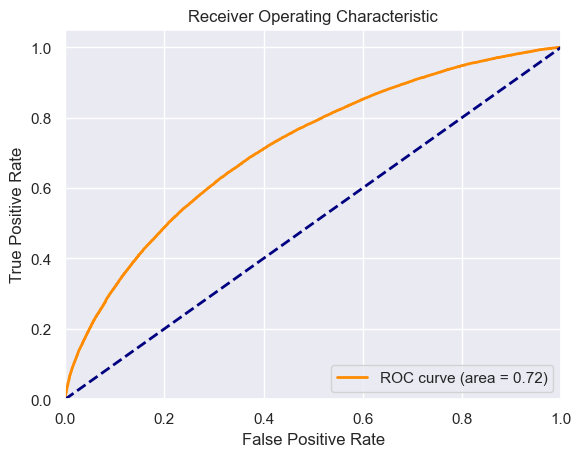

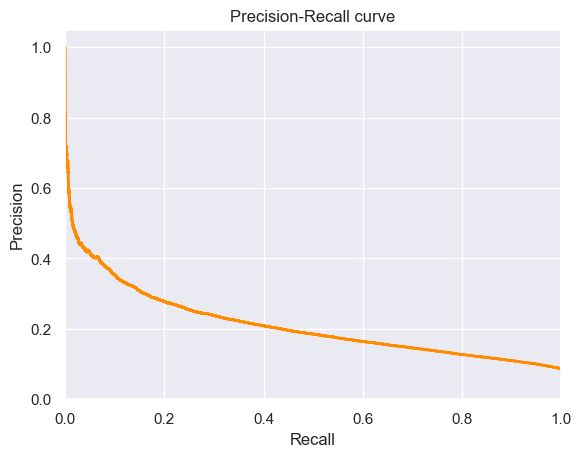

In [85]:
#check AUC
probs = lr.predict_proba(Xtest_selected_woe)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

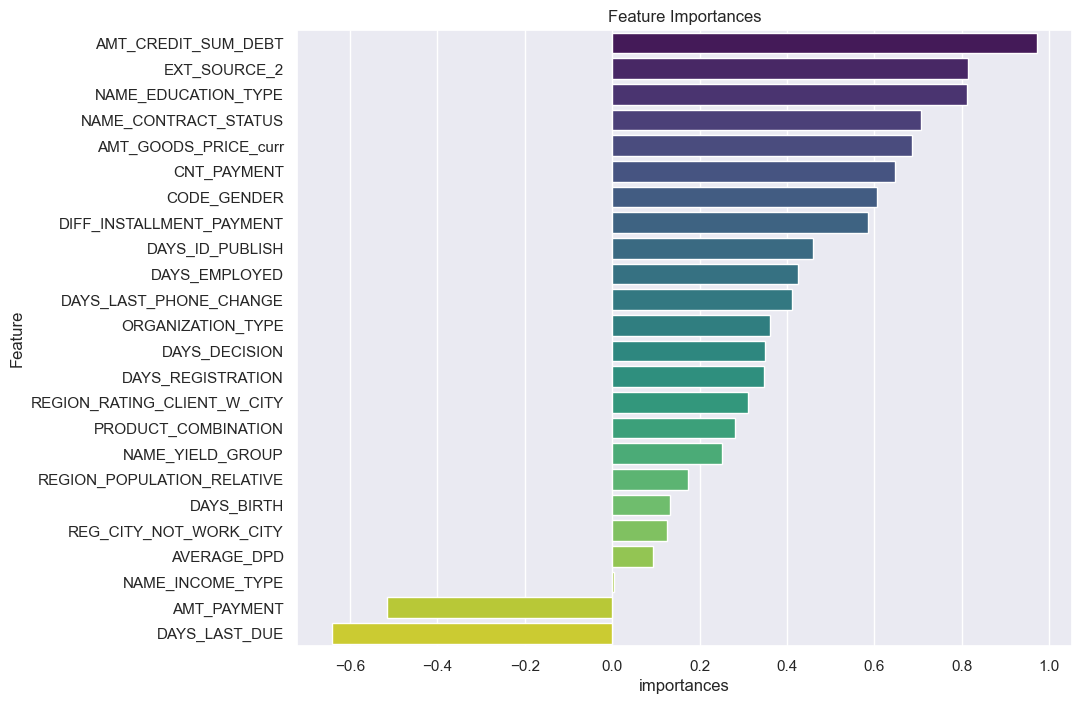

In [87]:
# get the feeature names
features = Xtrain_selected_woe.columns

# get the coefficients from lr model
coefficients = lr.coef_[0]

# create df for feat importancs
feat_importances = pd.DataFrame({'Feature': features,
                                 'importances': coefficients})

# sort df by importances
feat_importances = feat_importances.sort_values(by='importances', ascending=False)

# plot the importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_importances, x='importances', y='Feature', palette='viridis')
plt.title('Feature Importances')
plt.show()


In [88]:
# Get the coefficients from the logistic regression model
coefficients = logreg_new.coef_[0]

# Define the scaling factor and offset
factor = 20 / np.log(2)
offset = 600 - factor * np.log(20)

# Scale the coefficients
scaled_coefficients = (coefficients * factor)

# Create a dataframe for the scorecard
scorecard = pd.DataFrame({'Feature': Xtrain_selected_woe.columns, 'Score': scaled_coefficients})

# Calculate the scores for each observation
scores = Xtrain_selected_woe.dot(scaled_coefficients) + offset

In [89]:
fpr, tpr, thresholds = roc_curve(y_train['TARGET'], scores)

# Calculate the Youden's J statistic for each point on the ROC curve
J = tpr - fpr

# Step 4: Find the optimal cutoff point
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx] / 1000

print(f'Optimal cutoff point: {optimal_threshold}')

Optimal cutoff point: 0.5144971490486486


In [91]:
# # Transform test data
# Xtest_transformed = td.transform(c.transform(X_test))

# Use trained model to predict probabilities
test_probabilities = logreg_new.predict_proba(Xtest_selected_woe)[:, 1]

# Apply the optimal threshold to these probabilities to get binary predictions
test_predictions = (test_probabilities > optimal_threshold).astype(int)

# Create score levels based on the range of scores
bins = np.linspace(min(test_probabilities), max(test_probabilities), 6)  # Change the number of bins as needed
labels = range(5, 0, -1)  # Change the labels as needed
score_levels = pd.cut(test_probabilities, bins=bins, labels=labels)

# Create a DataFrame for easier plotting
cs_df = pd.DataFrame({
    'Score': test_probabilities,
    'Label': y_test['TARGET']  
})

In [92]:
# Apply the optimal threshold to the scores to classify clients
cs_df['Client Type'] = cs_df['Score'].apply(lambda x: 'Good' if x >= optimal_threshold else 'Bad')

# Print the DataFrame
cs_df

,Score,Label,Client Type
731711,0.722097,0,Good
480807,0.274755,0,Bad
1240274,0.346467,0,Bad
900521,0.330753,0,Bad
827722,0.260819,0,Bad
...,...,...,...
547023,0.253448,0,Bad
936177,0.178790,0,Bad
890763,0.686998,1,Good
299560,0.470793,0,Bad


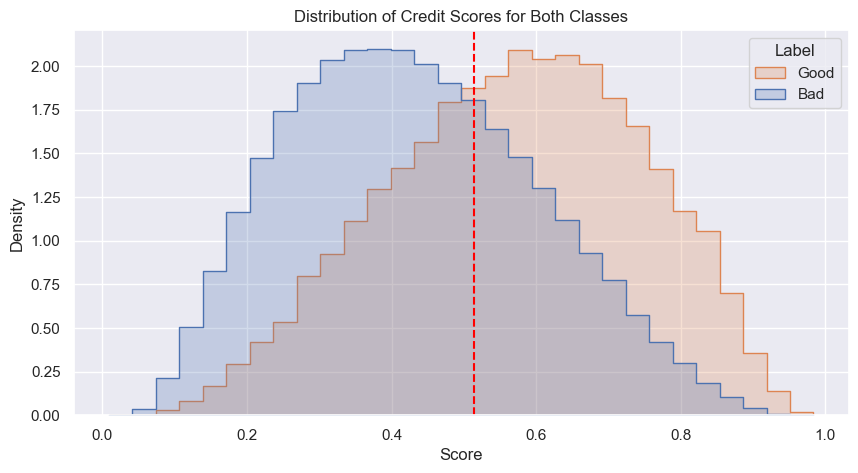

In [96]:
# Plot the distribution of scores for both classes
plt.figure(figsize=(10, 5))
sns.histplot(data=cs_df, x='Score', hue='Label', element='step', bins=30, stat='density', legend=True, common_norm=False)
plt.axvline(x=optimal_threshold, color='red', linestyle='--')
plt.title('Distribution of Credit Scores for Both Classes')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(title='Label', loc='upper right', labels=['Good', 'Bad'])
plt.show()

## Handling Outlier

In [38]:
# def cap_outliers(data, columns):
#     # Create a copy of the data to avoid modifying the original DataFrame
#     result = data.copy()

#     # Loop over each column in the provided list
#     for col in columns:
#         # Calculate the first quartile (Q1) for the current column
#         Q1 = result[col].quantile(0.25)
#         # Calculate the third quartile (Q3) for the current column
#         Q3 = result[col].quantile(0.75)
#         # Calculate the Interquartile Range (IQR) for the current column
#         IQR = Q3 - Q1
#         # Calculate the lower bound for the current column
#         lower_bound = Q1 - (1.5 * IQR)
#         # Calculate the upper bound for the current column
#         upper_bound = Q3 + (1.5 * IQR)
#         # Replace values in the current column that are less than the lower bound with the lower bound
#         result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
#         # Replace values in the current column that are greater than the upper bound with the upper bound
#         result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
#     # Return the DataFrame with capped outliers
#     return result

In [39]:
# # Select the names of all numerical columns in the DataFrame X_train_c2
# outliers = X_train_c2.select_dtypes(include='number').columns

# # Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# # This will cap the outliers in these columns, and the result is stored in X_train_c3
# X_train_c3 = cap_outliers(X_train_c2, outliers)

## Feature Engineering

In [40]:
# # x train categorical value binning
# X_train_c3['AGE'] = round(abs(X_train_c3['DAYS_BIRTH'] / 365.25)).astype(int)

# X_train_c3 = X_train_c3[X_train_c3.NAME_FAMILY_STATUS != 'Unknown']
# y_train = y_train.drop([194676, 868956])
# X_train_c3 = X_train_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                       'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

# mapping_dict = {'Family' : 'Companied',
#                 'Spouse, partner': 'Companied',
#                 'Children': 'Companied',
#                 'Other_A': 'Companied',
#                 'Other_B': 'Companied',
#                 'Group of people': 'Companied'}
# X_train_c3 = X_train_c3.replace({'NAME_TYPE_SUITE': mapping_dict})

# map_income_val = {'Unemployed': 'Others', 
#                   'Student': 'Others', 
#                   'Materniity leave': 'Others',
#                   'Businessman': 'Others'}

# X_train_c3 = X_train_c3.replace({'NAME_INCOME_TYPE': map_income_val})


# # x test categorical value binning
# X_test_c3 = X_test_c2.copy()
# X_test_c3['AGE'] = round(abs(X_test_c3['DAYS_BIRTH'] / 365.25)).astype(int)

# X_test_c3 = X_test_c3[X_test_c3.NAME_FAMILY_STATUS != 'Unknown']
# X_test_c3 = X_test_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                     'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

# X_test_c3 = X_test_c3.replace({'NAME_TYPE_SUITE': mapping_dict})
# X_test_c3 = X_test_c3.replace({'NAME_INCOME_TYPE': map_income_val})

## Feature Encoding

In [17]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder object
# le = LabelEncoder()

# X_train_c4 = X_train_c3.copy()
# # Iterate over all values of each column and extract their dtypes
# for col in X_train_c4.columns:
#     # Compare if the dtype is object
#     if X_train_c4[col].dtype == 'object':
#     # Use LabelEncoder to do the numeric transformation
#         X_train_c4[col] = le.fit_transform(X_train_c4[col])
#         X_test_c3[col] = le.fit_transform(X_test_c3[col])

In [41]:
# # one hot encoding all categorical columns
# X_train_c4 = pd.get_dummies(X_train_c3, drop_first=True).astype(int)
# X_test_c4 = pd.get_dummies(X_test_c3, drop_first=True).astype(int)

## Feature Scaling

In [42]:
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train_c4)

# X_test_scaled = scaler.transform(X_test_c4)

## Handle Imbalance data

In [27]:
# stomek = SMOTETomek(random_state=1103)
# X_over, y_over = stomek.fit_resample(X_train_scaled, y_train)

In [ ]:
# counts = y_over['TARGET'].value_counts()
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.patch.set_facecolor('#e6ebed')
# gbp = ['#69ba2d', '#d9000c']

# wedges, texts, autotexts = ax.pie(counts,
#                                    labels=['Good Clients', 'Bad Clients'],
#                                    autopct='%1.1f%%',
#                                    colors=gbp,
#                                    startangle=80)

# plt.axis('equal')
# for i, text in enumerate(texts):
#     text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
#     texts[i].set_fontsize(12)
# plt.show()

## Model Building

In [46]:
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     # Fit the model to the training data
#     model.fit(X_train, y_train)
    
#     # Make predictions on the training data
#     y_train_pred = model.predict(X_train)
    
#     # Make predictions on the testing data
#     y_test_pred = model.predict(X_test)
    
#     # Calculate the accuracy for the training and testing data
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Calculate the precision for the training and testing data
#     train_precision = precision_score(y_train, y_train_pred)
#     test_precision = precision_score(y_test, y_test_pred)
    
#     # Calculate the recall for the training and testing data
#     train_recall = recall_score(y_train, y_train_pred)
#     test_recall = recall_score(y_test, y_test_pred)
    
#     # Calculate the F1 score for the training and testing data
#     train_f1 = f1_score(y_train, y_train_pred)
#     test_f1 = f1_score(y_test, y_test_pred)

#     # Calculate the ROC AUC for the training and testing data
#     train_roc_auc = roc_auc_score(y_train, y_train_pred)
#     test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
#     return {
#         'model': model.__class__.__name__,
#         'train_recall': round(train_recall, 2),
#         'test_recall': round(test_recall, 2),
#         'train_roc_auc': round(train_roc_auc, 2),
#         'test_roc_auc': round(test_roc_auc, 2)
#     }

In [60]:
# # import xgboost model
# from xgboost import XGBClassifier

# # import gradient boosting model
# from sklearn.ensemble import GradientBoostingClassifier

# lr = LogisticRegression(random_state=1103, class_weight='balanced')
# xgb = XGBClassifier(random_state=1103)
# gbc = GradientBoostingClassifier(random_state=1103)

# models = [lr, xgb]

# results = [evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test) for model in models]

# # Convert the results to a DataFrame
# df_model = pd.DataFrame(results)

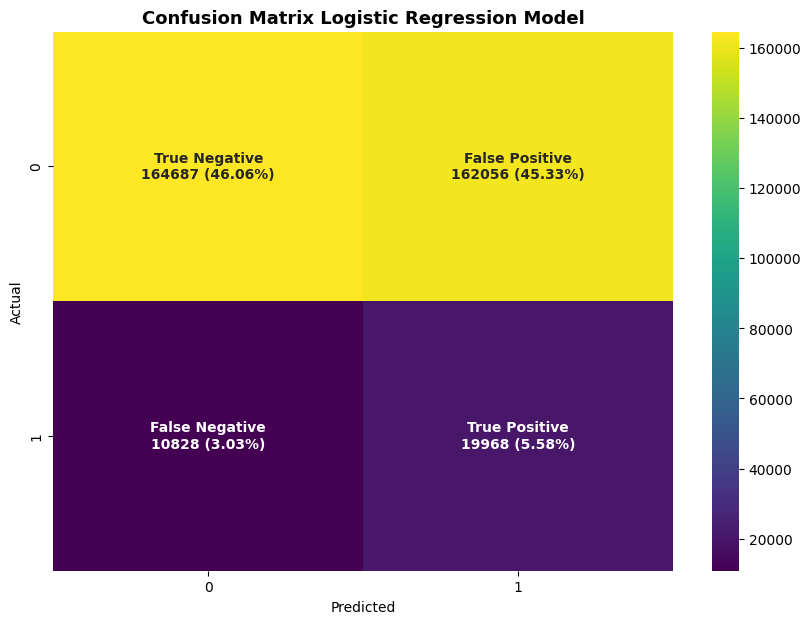

In [53]:
# # Assuming X_test is your test dataset and model is your Gradient Boosting model
# y_pred = lr.predict(X_test_scaled)

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate the percentage of each category
# percentage_matrix = cnf_matrix / cnf_matrix.sum()

# # Define the labels
# labels = np.array([['True Negative', 'False Positive'],
#                    ['False Negative', 'True Positive']])

# # Create labels with both count and percentage
# new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
#                           for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
#              ).reshape(2,2)

# # Plot confusion matrix using a heatmap
# fig = plt.figure(figsize=(10,7))
# fig.patch.set_facecolor('white')  # Change figure color

# sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
# plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')

# # Change label colors
# plt.gca().xaxis.label.set_color('black')
# plt.gca().yaxis.label.set_color('black')

# plt.show()